In [2]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg

In [7]:
#读入所有图书
def get_all_books():
    books = []
    for file in os.listdir(os.getcwd()+ '/data'):
        if file.endswith('.json'):
            books.append(file)

    df = pd.DataFrame()
    for book in books:
        df = df.append(pd.read_json('data/'+book))
    df = df.drop_duplicates(subset='book_id')
    df = df.reset_index(drop=True)
    return df

## 描述性统计

In [8]:
df=get_all_books()

In [29]:
# 看看评分和评价人数的关系，评价多的热门书是不是分数会比较高
linear_model = smf.ols(formula='score ~ eveluate_nums', data=df)
results = linear_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     327.0
Date:                Wed, 09 Nov 2016   Prob (F-statistic):           2.49e-72
Time:                        10:41:08   Log-Likelihood:                -40628.
No. Observations:               14935   AIC:                         8.126e+04
Df Residuals:                   14933   BIC:                         8.128e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         2.9215      0.030     96.580      0.000         2.862     2.981
eveluate_nums     0.0003   1.47e-05     18.084      0.000         0.000     0.000
==============================================================================
Omnibus:                      434.262   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1663.045
Skew:                           0.436   Prob(JB):                         0.00
Kurtosis:                       1.617   Cond. No.                     2.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

相关性极小，说明我的猜测是错的。

In [12]:
#评分最高的十本书

df[['title','score','author','publisher','eveluate_nums']].sort_values(by=['score','eveluate_nums'],ascending=False)[:10]

,title,score,author,publisher,eveluate_nums
2574,行动的勇气,9.9,〔美〕本·伯南克,中信出版社,146
5188,互联网+：传统行业跨界融合与转型升级新模式,9.7,陈国嘉,人民邮电出版社,24
5990,武志红心智成长系列（三册套装）,9.6,武志红,磨铁数盟,20
12364,飘,9.5,〔美〕玛格丽特·米切尔,译林出版社,486
1149,人生的智慧,9.5,〔德〕叔本华,上海人民出版社,176
11234,女神从来不慌张,9.5,辫子歪歪,斯坦威图书,62
164,实践理性批判（注释本）,9.5,〔德〕康德,中国人民大学出版社,51
5113,深入理解C#（第3版）,9.5,〔英〕斯基特 (Jon Skeet),图灵社区,41
5696,爱是唯一的真相,9.5,〔美〕布莱恩· 魏斯,博集天卷,25
3051,微商团队管理实战手册,9.5,杜一凡,人民邮电出版社,22


除了《飘》，其他的都没听过，评价人数也偏少

In [19]:
#增加评价人数的条件
index_high = (df.score >=8)
index_popular = df.eveluate_nums >= 5000
top_list = index_high & index_popular
df[top_list][['title','score','author','publisher','eveluate_nums']].sort_values(by=['score','eveluate_nums'],ascending=False)[:10]

,title,score,author,publisher,eveluate_nums
3,人类简史：从动物到上帝,9.3,〔以〕尤瓦尔·赫拉利,中信出版社,14029
6384,三体2：黑暗森林,9.2,刘慈欣,N,71763
6381,三体3：死神永生,9.2,刘慈欣,N,71365
7564,白夜行,9.2,〔日〕东野圭吾,新经典文化电子书,48483
12375,夹边沟记事,9.1,杨显惠,N,10719
12026,寻路中国,9.0,〔美〕彼得·海斯勒,上海译文出版社,28455
12025,江城,9.0,〔美〕彼得·海斯勒,上海译文出版社,20580
12353,巨人的陨落（共3册）,9.0,〔英〕肯·福莱特,读客图书,6343
6324,最好的告别,9.0,〔美〕阿图·葛文德,湛庐文化,6318
6391,银河帝国：基地,9.0,〔美〕艾萨克·阿西莫夫,读客图书,5103


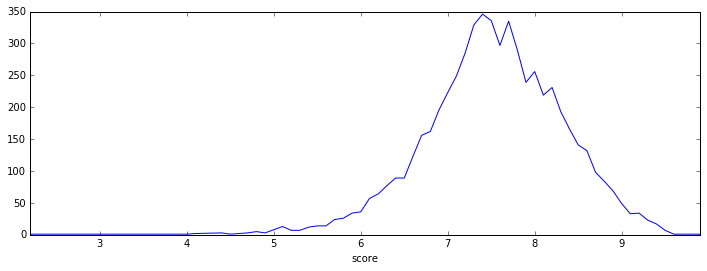

In [26]:
#把没有评分的剔除，查看评分的分布
dfscore=df[df.score>0].groupby("score")["score"].count()
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dfscore.plot(kind='line',ax=ax)


## 对图书目录的分析

In [37]:
#从图书标签和标题中搜索，筛选符合条件的图书
def get_books(string):
    df=get_all_books()
    arr=[]
    for rIndex in df.index:
            if (string in df.iloc[rIndex].tags)  or str(df.iloc[rIndex].title).find(string)>=0:
                arr.append(df.iloc[rIndex])
    return pd.DataFrame(arr)

In [44]:
#以数据分析为例
df_target=get_books('数据分析')
df_target = df_target.reset_index(drop=True)

In [45]:
df_target

,author,book_id,category,desc,eveluate_nums,price,publisher,score,table_contents,tags,title,url
0,〔美〕Allen B.Downey,5309999,图书 / 非虚构,本书正是一本概率统计方面的入门图书，但视角极为独特，折射出大数据浪潮的别样风景。作者将基本的...,109,18.00,图灵社区,6.5,"[统计思维, O'Reilly Media, Inc.介绍, 译者序, 前言, 程序员的统...","[计算机, 统计, 编程, 数学, 数据分析, Python]",统计思维,https://read.douban.com/ebook/5309999/
1,〔美〕卡巴科佛,1132951,图书 / 非虚构,R是一个开源项目，具有强大的统计计算及制图能力，是从大数据中获取有用信息的绝佳工具，在各种主...,433,40.00,图灵社区,8.8,"[那些年，我们一起学过的R语言, 译 者 致 谢, 前 言, 关 于 本 书, 关于封面图片...","[计算机, 统计, 编程, 数据挖掘, 数据分析, 计算机与互联网]",R语言实战,https://read.douban.com/ebook/1132951/
2,〔美〕Toby Segaran,1169260,图书 / 非虚构,本书通过世界上最好的数据工作者的示例，向读者展示处理数据的方法。本书使得读者可以站在优秀的数...,257,12.00,华章数媒,7.2,"[数据之美, O'Reilly Media,Inc.介绍, 译者序, 前言, 在数据中观察...","[计算机, IT, 数据分析, 算法, 数据, 计算机与互联网]",数据之美,https://read.douban.com/ebook/1169260/
3,〔美〕Nathan Yau,1052447,图书 / 非虚构,在生活中，数据几乎无处不在，任我们取用。然而，同样的数据给人的感觉可能会千差万别：或冰冷枯燥...,260,30.00,图灵社区,7.6,"[鲜活的数据, 引言, 可视化, 学习数据, 如何阅读本书, 用数据讲故事, 1不只是数字,...","[互联网, 计算机, 数据可视化, 设计, 数据分析, 可视化, 数据, 豆瓣自习室, 计算...",鲜活的数据,https://read.douban.com/ebook/1052447/
4,张良均,17420921,图书 / 非虚构,本书共14章，分三个部分：基础篇、实战篇、高级篇。基础篇介绍了数据挖掘、Hadoop大数据的...,0,25.00,华章数媒,0.0,"[1 某知名连锁餐饮企业的困惑, 2 从餐饮服务到数据挖掘, 3 数据挖掘的基本任务, 4 ...","[网络, 计算机, 大数据, 数据库]",Hadoop大数据分析与挖掘实战,https://read.douban.com/ebook/17420921/
5,张建伟,16878776,图书 / 非虚构,由浅入深，循序渐进：本书以初级和中级读者为对象，首先从Origin使用基础讲起，再辅以Ori...,8,35.40,人民邮电出版社,0.0,"[1.1 Origin 9.0特点, 1.2 Origin 9.0功能, 1.3 发展历程,...","[网络, 计算机, IT, Origin]",Origin 9.0科技绘图与数据分析超级学习手册,https://read.douban.com/ebook/16878776/
6,〔美〕麦金尼（Wes McKinney）,15249337,图书 / 非虚构,还在苦苦寻觅用Python控制、处理、整理、分析结构化数据的完整课程？本书含有大量的实践案例...,288,30.00,华章数媒,8.5,"[把Python当做粘合剂, 解决“两种语言”问题, 为什么不选Python, NumPy,...","[计算机, 编程, python, 数据挖掘, 数据分析]",利用Python进行数据分析,https://read.douban.com/ebook/15249337/
7,〔美〕 Richard Cotton,12056633,图书 / 非虚构,本书分为上下两部分，旨在指导你如何使用R，并提供练习的机会。上半部分主要介绍R的技术细节和使...,17,29.99,图灵社区,7.3,"[O'Reilly Media,Inc.介绍, 业界评论, 译者序, 前言, 关于本书, 本...","[计算机, R, 统计, 编程, 数据挖掘, 数据分析]",学习R,https://read.douban.com/ebook/12056633/
8,秦志光,23982581,图书 / 非虚构,《智慧城市中的大数据分析技术》以智慧城市和大数据技术之间的本质联系为出发点，通过生动的案例从...,0,52.80,人民邮电出版社,0.0,"[4.1 国外智慧城市建设的关键要素分析, 4.2 国内智慧城市建设的关键要素分析, 4.1...","[计算机, 大数据, 城市建设]",智慧城市中的大数据分析技术,https://read.douban.com/ebook/23982581/
9,〔印尼〕 Ivan Idris,12052260,图书 / 非虚构,NumPy是一个优秀的科学计算库，提供了很多实用的数学函数、强大的多维数组对象和优异的计算性...,29,19.99,图灵社区,6.2,"[献辞, 译者序, 关于审稿人, 前言, NumPy是什么, NumPy的由来, 为什么使用...","[计算机, 数学, python, 数据挖掘, 数据分析]",Python数据分析基础教程,https://read.douban.com/ebook/12052260/


In [140]:
#数据清洗，把常见的标题引语删除
import re
def trim_word(strings):
    newstring=[]
    for string in strings:
        r=re.compile(r'^第.*节|^第.*部分|^序言|^前言|^附录|^导读|^致谢|^引言|^第.*部|^第.*卷|^\d{1,2}.\d{1,2}|^\d{1,3}\s|小结') 
        newstring.append(r.sub('',string))
    return newstring

In [125]:
df_target.clean_contents=df_target.table_contents.apply(trim_word)

In [126]:
df_target.clean_contents

0     [统计思维, O'Reilly Media, Inc.介绍, 译者序, ,  程序员的统计思...
1     [那些年，我们一起学过的R语言, 译 者 致 谢, 前 言, 关 于 本 书, 关于封面图片...
2     [数据之美, O'Reilly Media,Inc.介绍, 译者序, ,  在数据中观察生活...
3     [鲜活的数据, , 可视化, 学习数据, 如何阅读本书, 用数据讲故事, 1不只是数字,  ...
4     [某知名连锁餐饮企业的困惑, 从餐饮服务到数据挖掘, 数据挖掘的基本任务, 数据挖掘建模过程...
5     [ Origin 9.0特点,  Origin 9.0功能,  发展历程,  软件应用,  ...
6     [把Python当做粘合剂, 解决“两种语言”问题, 为什么不选Python, NumPy,...
7     [O'Reilly Media,Inc.介绍, 业界评论, 译者序, , 关于本书, 本书主...
8     [ 国外智慧城市建设的关键要素分析,  国内智慧城市建设的关键要素分析,  纽约的电子治理,...
9     [献辞, 译者序, 关于审稿人, , NumPy是什么, NumPy的由来, 为什么使用Nu...
10    [安装环境（如下表所示）,  CM支持的操作系统（如下表所示）, 支持的数据库, 支持的JD...
11    [一些常用的操作习惯, 走出数据源表制作误区, 动手编制数据源表, , 轻松搞定特殊数据的录...
12    [本书涵盖以下内容, 阅读须知, 本书面向的读者对象, 每章的内容安排, 本书约定, 本书相...
13    [为什么要写这本书, 读者对象, 如何阅读本书, 勘误和支持, , R是最值得学习的编程语言...
14    [Excel 2010表格制作与数据分析范例应用, ,  行政管理表格, 行政与办公事务管理...
15    [数据科学实战, O'Reilly Media, Inc.介绍, 业界评论, 作者介绍, 关...
16    [机器学习：实用案例解析, 作者介绍, 译者介绍, 封面介绍, O'Reilly Media...
17    [精通搜索分析, O’Reilly Media,Inc.介绍, 业界评论, 译者序,

In [52]:
#用结巴进行分词
import jieba
def get_words(strings):
    s = []
    new_string=[]
    # for word, weight in jieba.analyse.extract_tags(string, topK=10,withWeight=True):
    pun = [u'【',u'】',u'（',u'）',u'，',u',',u'。',u'？',u'！',u'!',u'；',u'、',u'：',u'-',u'%',u'(',u')',u':',u'.',u':',u'"',u'$',u'~',u'\u3000',u'的',u'']
    for string in strings:
        s=jieba.lcut(string,cut_all=False)
        new_s = filter(lambda x: x not in pun, s)
        new_string.append(' '.join(new_s))
    return new_string

In [127]:
#直接对一本书目录分词的结果
print(get_words(df_target.clean_contents[0]))

['统计 思维', "O ' Reilly   Media   Inc 介绍", '译者 序', '', '  程序员 统计 思维', '第一个 孩子 出生 晚 吗', '统计 方法', '全国 家庭 成长 调查', '表 和 记录', '显著性', '术语', '  描述性 统计 量', '均值 和 平均值', '方差', '分布', '直方图 表示', '绘制 直方图', '表示 概率 质量 函数', '绘制 概率 质量 函数', '异常 值', '其他 可视化 方法', '相对 风险', '条件 概率', '汇报 结果', '术语表', '  累积 分布 函数', '选课 人数 之谜', 'PMF 不足', '百分位 数', '累积 分布 函数', 'CDF 表示', '回到 调查 数据', '条件 分布', '随机数', '汇总 统计 量', '术语表', '  连续 分布', '指数分布', '帕累托 分布', '正态分布', '正态 概率 图', '对数 正态分布', '为什么 需要 模型', '生成 随机数', '术语', '  概率', '概率 法则', '蒙提 霍尔 问题', '庞加莱', '其他 概率 法则', '二项分布', '连胜 和 手感', '贝叶斯 定理', '术语', '  分布 运算', '偏度', '随机变量', '概率密度函数', '卷积', '正态分布 性质', '中心 极限 定理', '分布 函数 之间 关系 框架', '术语表', '  假设检验', '均值 差异 检验', '阈值 选择', '效应 定义', '解释 统计 检验 结果', '交叉 验证', '报道 贝叶斯 概率 结果', '卡方 检验', '高效 再 抽样', '功效', '术语', '  估计', '关于 估计 游戏', '方差 估计', '误差', '指数分布', '置信区间', '贝叶斯 估计', '贝叶斯 估计 实现', '删失 数据', '火车头 问题', '术语', '  相关性', '标准分数', '协方差', '相关性', '用 pyplot 画 散点图', '斯皮尔曼 秩 相关', '最小 二乘 拟合', '拟合 优度', '相关性 和 因果关系', '术语']


In [63]:
#对每一行目录分词后，全部连接成为一个字符串
def get_words_all(strings):
    s = []
    new_string=[]
    # for word, weight in jieba.analyse.extract_tags(string, topK=10,withWeight=True):
    pun = [u'【',u'】',u'（',u'）',u'，',u',',u'。',u'？',u'！',u'!',u'；',u'、',u'：',u'-',u'%',u'(',u')',u'”',u'.',u':',u'“',u'$',u'~',u'\u3000',u'的']
    for string in strings:
        s=jieba.lcut(string,cut_all=False)
        new_s = filter(lambda x: x not in pun, s)
        new_string.append(' '.join(new_s))
        
    return ' '.join(new_string)

In [132]:
#对每本书的目录进行分词,存储到cut_contents中
df_target.cut_contents=df_target.clean_contents.apply(get_words_all)


In [77]:
#用结巴获取权重高的词语，作为关键词
import jieba.analyse
print(jieba.analyse.extract_tags(df_target.cut_contents[0], topK=10, withWeight=True) )

[('概率', 0.2859129390162963), ('术语', 0.26391838074857144), ('10', 0.253010952442328), ('贝叶斯', 0.24546227638095236), ('分布', 0.21693664412656086), ('术语表', 0.189758214331746), ('函数', 0.18740586696772488), ('统计', 0.18107826173841268), ('正态分布', 0.16719653685714286), ('估计', 0.15892801011719576)]


In [70]:
def get_keyword(string):
    return jieba.analyse.extract_tags(string, topK=10)

In [129]:
#把每本书的关键词提取出来，存到keywords中
df_target.keywords=df_target.cut_contents.apply(get_keyword)
print(df_target.keywords)

0         [概率, 术语, 贝叶斯, 分布, 术语表, 函数, 统计, 正态分布, 估计, 相关性]
1            [数据, 检验, 回归, 变量, 方差分析, 图形, 缺失, 导入, 函数, 模型]
2        [数据, 参考文献, 结论, 结束语, 可视化, 之美, DNA, 实例, 简介, Web]
3            [可视化, 可选项, 数据, 寻求, 取舍, 堆叠, 柱形, 工具, 有关, 圆点]
4          [上机, 分析方法, 数据挖掘, 思考, 拓展, 挖掘, 实验, 背景, 概述, 目标]
5       [窗口, Origin, 图形, 拟合, 选项卡, 图层, 创建, 多峰, 工具栏, 3.2]
6          [索引, 函数, 数组, 分组, 示例, Python, 数据, 采样, 格式, 运算]
7             [测试, 知识, 练习, 本章, 目标, 列表, 字符串, 问题, 因子, 向量]
8     [数据, 架构, Hadoop, 数据分析, Mahout, 关键技术, 智慧, 体系, 分...
9           [动手, 实践, 刚才, 什么, 数组, NumPy, 函数, 绘制, 矩阵, 计算]
10       [示例, UDF, 子句, 连接, 配置, SQL, Impala, 压缩, 信息, 参数]
11          [函数, 查找, 透视, 表之, 实战, 计算, 数据, Excel, 日期, 录入]
12       [创建, 引言, 数据, 分类, 读取数据, Java, 回归, 变量, 空间数据, 函数]
13    [安装, Ubuntu, 语言, Windows, Java, Redis, 客户端, RH...
14            [设计, 分析, 管理, 函数, 表格, 统计表, 计算, 数据, 员工, 单价]
15           [模型, 数据, 可视化, 思维, 示例, 实验, 算法, 关于, 科学家, 科学]
16      [回归, 社交, 排序, 简介, 可视化, 邮件, 分类器, 数据, Twitter, 聚类]
17        [搜索, 追踪, SEO, 关键词, 付费, 站内搜索, ROI, 页面, 

In [133]:
#把所有关键词放在一起，再求一次关键词

text=""
for keyword in df_target.keywords:
    text=text+' '.join((keyword))
print(jieba.analyse.extract_tags(text, topK=10))

['数据', '函数', '可视化', '示例', 'Python', '数据挖掘', '聚类', 'Hadoop', 'Java', '上机']


以上是对“数据分析”相关书籍的目录进行分析后，求得的核心概念。应该说不怎么精确，样本量小，算法也过于简单。

In [142]:
#把上述处理过程封装成函数
def get_core(string):
    df_target=get_books(string)
    df_target = df_target.reset_index(drop=True)
    df_target.clean_contents=df_target.table_contents.apply(trim_word)
    df_target.cut_contents=df_target.clean_contents.apply(get_words_all)
    df_target.keywords=df_target.cut_contents.apply(get_keyword)
    text=""
    for keyword in df_target.keywords:
        text=text+' '.join((keyword))
    return text  #返回书籍的所有关键词

In [143]:
# 查看心理学书籍
text_core=get_core('心理学')

In [144]:
print(jieba.analyse.extract_tags(text_core, topK=10))

['心理', '心理学', '自我', '自己', '情绪', '人生', '性格', '如何', '对方', '职场']


In [ ]:
## 用词云显示结果

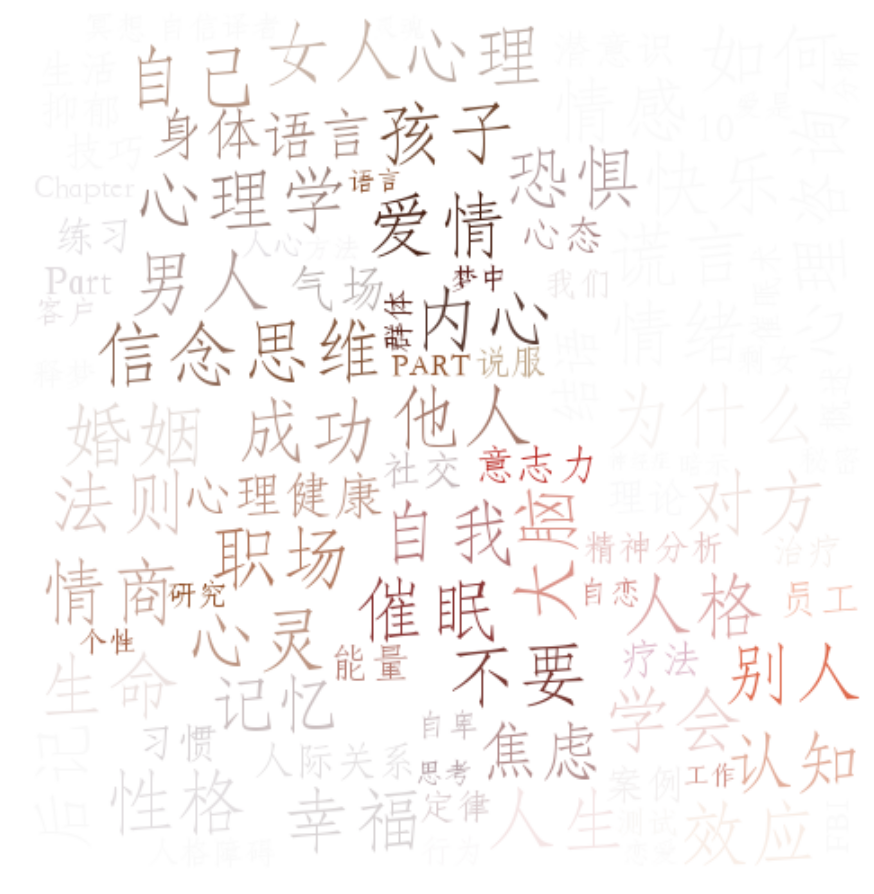

In [148]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from scipy.misc import imread
word_list=jieba.analyse.extract_tags(text_core, topK=100, withWeight=True)
base_image = imread("book.jpg")
wc = WordCloud(background_color="white",  stopwords=STOPWORDS.add("结语"),font_path='/Library/Fonts/华文仿宋.ttf', 
               max_words=100, mask=base_image,max_font_size=40, random_state=42)
wc.generate_from_frequencies(word_list)
image_colors = ImageColorGenerator(base_image)
plt.figure(figsize = (15,30))
plt.imshow(wc.recolor(color_func=image_colors),aspect='equal')
plt.axis("off")
plt.show()